In [2]:
# Common imports

import pandas as pd
import numpy as np
import os 
import sys
import math
import utm
import time

import json
import geopandas as gpd
import fiona

from numba import jit

from shapely.geometry import shape, mapping

from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from bokeh.plotting import figure, output_file, show, output_notebook
from bokeh.plotting import ColumnDataSource
from bokeh.transform import factor_cmap, factor_mark
from bokeh.palettes import Spectral3

from bokeh.layouts import gridplot

from radar_scrape import get_radar_img_urls, request_img_files
from get_station_data import get_daily_runoff

import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

output_notebook()


Loading BokehJS ...

In [3]:
BASE_DIR = os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath(''))))
DB_DIR = os.path.join(BASE_DIR, 'code/hydat_db')
PROJECT_DIR = os.path.abspath('')
RADAR_IMG_DIR = os.path.join(PROJECT_DIR, 'sorted_radar_images')
CROPPED_IMG_DIR = os.path.join(PROJECT_DIR, 'data/masked_img')
RESULTS_DIR = os.path.join(PROJECT_DIR, 'data/AD_results')

In [4]:
stations_df = pd.read_csv(DB_DIR + '/WSC_Stations_Master.csv')

# list the stations whose catchments fall off the edge of the map
incomplete_stns = pd.read_csv(os.path.join(PROJECT_DIR,'data/incomplete_sites.txt')).columns.values
masked_stns = os.listdir(CROPPED_IMG_DIR)


In [5]:
# retrieve the results dataframe for the specified site
results_folders = os.listdir(RESULTS_DIR)

results_dict = {}
# create a dictionary of results from all AD searches
for f in results_folders:
    folder_path = os.path.join(RESULTS_DIR, f)
    all_sites = [e.split('_')[0] for e in os.listdir(folder_path)]
    for site in all_sites:
        if site in results_dict.keys():
            old_results = results_dict[site]
            new_results = pd.read_csv(os.path.join(folder_path, site + '_results.csv'))
            results_dict[site] = pd.concat([old_results, new_results], sort=True)
        else:            
            results_dict[site] = pd.read_csv(os.path.join(folder_path, site + '_results.csv'))


def get_best_result(site):
    ad_df = pd.DataFrame(results_dict[site])
    ad_df.drop(labels='Unnamed: 0', inplace=True, axis=1)
    ad_df.sort_values('len_results', inplace=True, ascending=False)
    return ad_df.iloc[0, :]

In [7]:
stations = os.listdir(CROPPED_IMG_DIR)

# iterate through the files and format
# the filenames as timestamps
def convert_str_to_datetime(s):
    s = s.values[0]
    return pd.to_datetime(s[:4] + '-' + s[4:6] + '-' + s[6:8] + ' ' + s[8:10] + ':' + s[10:12] )



In [8]:
# stations = 
event_dict = {}
for stn in masked_stns:
    dates_df = pd.DataFrame()
    event_dict[stn] = {}
    images = os.listdir(os.path.join(CROPPED_IMG_DIR, stn))
    dates_df['dt_strings'] = [e.split('_')[0] for e in images]
    dates_df['datetime'] = dates_df.apply(lambda x: convert_str_to_datetime(x), axis=1)
    dates_df = dates_df.sort_values(by='datetime')
    dates_df['dt_hours'] = dates_df['datetime'].diff(1).astype('timedelta64[h]')
    dates_df.reset_index(inplace=True, drop=True)
    break_ixs = dates_df[dates_df['dt_hours'] > 24].index
    last_ix = 0
    n = 0
    for ix in range(1, len(break_ixs)):
        dt_strings_array = dates_df.loc[break_ixs[ix - 1]:break_ixs[ix] - 1, 'dt_strings'].to_numpy()
        event_dict[stn][n] = dt_strings_array
        n += 1

In [9]:
# first, create a dictionary for mapping radar precip colors to mm/hr rates
cbar_path = os.path.join(PROJECT_DIR, 'img')
radar_cmap_img = Image.open(os.path.join(cbar_path, 'colorbar.png')).convert('RGB')
cmap_array = np.asarray(radar_cmap_img).astype(np.uint8)  
print('dim of cmap array = ', cmap_array.shape)
c_width, c_height = 20, 14

colour_map_dict = {}
intensities = [0.1, 1., 2., 4., 8., 12., 16., 24., 36., 50., 75., 100., 150., 200.][::-1]
for n in range(14):
    this_color = cmap_array[n * 14:n * 14 + 14, :][0,0,:]
    colour_map_dict[str(list(this_color))] = float(intensities[n])
    
# add an entry for zero or null
colour_map_dict[str(list([150, 150, 150]))] = 0.
colour_map_dict[str(list([0, 0, 0]))] = 0.



dim of cmap array =  (196, 20, 3)


In [10]:
for stn in masked_stns:
    folder_path = os.path.join(CROPPED_IMG_DIR, stn)
    if len(os.listdir(folder_path)) == 0:
#         print('empty: ', stn)
        os.rmdir(folder_path)
    
print(len(os.listdir(CROPPED_IMG_DIR)))

126


In [71]:
def retrieve_image(datetime_string, stn):
    folder_path = os.path.join(CROPPED_IMG_DIR, stn)
    cropped_radar_img = Image.open(os.path.join(folder_path, str(datetime_string) + '_crp.gif')).convert('RGB')
#     print(np.asarray(cropped_radar_img).astype(np.uint8))
#     print(cropped_radar_img)
    return np.asarray(cropped_radar_img).astype(np.uint8)

def convert_pixel_color_to_precip_volume(row, stn):
    datetime_string = row['time_string']
    duration = row['dt']
    img_array = retrieve_image(datetime_string, stn)
    rows = img_array.shape[0]
    cols = img_array.shape[1]
    vol_array = np.zeros((rows, cols, 1))
    for r in range(rows):
        for c in range(cols):
            map_color = str(list(img_array[r, c]))
            if map_color in list(colour_map_dict.keys()):
                # convert mm/h to m^3
                total_vol = colour_map_dict[map_color] * duration * 1000**2 / 1000
                vol_array[r, c] = total_vol
            else:
                vol_array[r, c] = 0
    return vol_array.flatten().sum()


def construct_unit_hydrograph(stn, event_timestamps):
    event_df = pd.DataFrame()
    event_df['time_string'] = event_timestamps
    event_df['datetime'] = event_df.apply(lambda x: convert_str_to_datetime(x), axis=1)
    event_df['dt'] = event_df['datetime'].diff(-1).astype('timedelta64[h]') * -1
    event_df['precip_vol'] = event_df.apply(lambda row: convert_pixel_color_to_precip_volume(row, stn), axis=1)
    return event_df

def concatenate_precip_and_flow(stn, event):
    precip_df = construct_unit_hydrograph(stn, event)
    precip_df.set_index('datetime', inplace=True)
    precip_df = precip_df.resample('1D').sum()
    
    precip_df['cumsum_m3'] = precip_df['precip_vol'].cumsum()
    precip_df['precip_rate_cms'] = precip_df['precip_vol'] / 24 / 3600
    
    ## find the concurrent flow record
    flow_df = get_daily_runoff(stn)
    flow_df.rename(columns={'DAILY_FLOW': 'flow_cms'}, inplace=True)
    flow_df['Year'] = flow_df.index.year
    flow_df['Month'] = flow_df.index.month
    
    df = pd.concat([precip_df, flow_df[['flow_cms']]], join='inner', axis=1)
    df = df[['precip_rate_cms', 'flow_cms']]
    event_duration = (df.index[-1] - df.index[0]).days
    if event_duration >= 2:
        return df
    else:
        return None


def create_plot_grid(stn):
    
    n_events = len(event_dict[stn])
    
    plots = []    
    for event in event_dict[stn]:
        # parse a single event pair
        this_event_df = concatenate_precip_and_flow(stn, event_dict[stn][event])
        if this_event_df is not None:
            s1 = figure(background_fill_color="#fafafa", x_axis_type='datetime')  
            s1.xaxis.major_label_orientation = math.pi/2
            s1.line(this_event_df.index, this_event_df['precip_rate_cms'], color='green')
            s1.line(this_event_df.index, this_event_df['flow_cms'], color='blue')
            plots.append(s1)    
    return plots


def arrange_plots_into_grid(stn_plots):
    stn = stn_plots[0]
    plots = stn_plots[1]
    stn_info = stations_df[stations_df['Station Number'] == stn]
    stn_DA = stn_info['Gross Drainage Area (km2)'].values[0]
    print('Station: {} ({} km^2)'.format(stn, stn_DA))
    n_cols = 5
    n_rows = int(np.ceil(len(plots) / n_cols))

    g = []
    for i in range(0, len(plots), n_cols):
        g += [plots[i:i+n_cols]]
    grid = gridplot(g, plot_width=150, plot_height=150)
    return grid

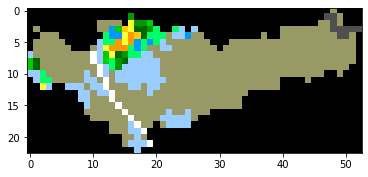

In [72]:
foo = retrieve_image('200906130000', '05BL014')
# print(foo.shape)
plt.imshow(foo)

### New Game -- Create 2d histogram plots to show where rain falls

In [73]:
def get_sample_img(stn):
    """
    I think what I'm trying to do here is find an image that's 
    free from the colouration of precipitation.  The 'sample image'
    in this case is one which has no cell that is coloured 
    with one of the 14 colours reserved for precipitation.
    """
    event = event_dict[stn][0]
    precip_in_frame = False
    map_colors = [e for e in list(colour_map_dict.keys()) if e != '[0, 0, 0]']
    min_paint = 1E12
    date = None
    for e in event:
        img_array = retrieve_image(e, stn)
        rows = img_array.shape[0]
        cols = img_array.shape[1]
        n_colors = 0
        for r in range(rows):
            for c in range(cols):
                map_color = str(list(img_array[r, c]))
                if map_color in map_colors:
                    precip_in_frame = True
                    n_colors += 1
                elif map_color == '[0, 0, 0]':
                    img_array[r, c] = np.asarray([0, 0, 0])
        if n_colors < min_paint:
            min_paint = n_colors
            best_img_event = e
                    
        if precip_in_frame == False:
            return Image.fromarray(img_array, 'RGB')

    return Image.fromarray(retrieve_image(best_img_event, stn))

@jit
def reset_bg_colors(base_img_array, new_img):
    rows = base_img_array.shape[0]
    cols = base_img_array.shape[1]
    for r in range(rows):
            for c in range(cols):
                base_color = base_img_array[r, c]
#                 print(base_color, type(base_color))
                if (base_color == np.zeros(3)).all():
                    new_img[r, c] = np.nan
    return new_img
    
    

In [64]:
from sklearn.preprocessing import normalize

def convert_pixel_color_to_precip_count(row, stn):
    datetime_string = row['time_string']
    duration = row['dt']
    if np.isnan(row['dt']):
        duration = 1
    img_array = retrieve_image(datetime_string, stn)
    rows = img_array.shape[0]
    cols = img_array.shape[1]
    count = np.zeros((rows, cols))
    precip_colors = [e for e in list(colour_map_dict.keys()) if e != '[0, 0, 0]']
    for r in range(rows):
        for c in range(cols):
            map_color = str(list(img_array[r, c]))
            if map_color in precip_colors:
                # convert mm/h to m^3
                weighted_count = float(colour_map_dict[map_color]) * duration
                count[r, c] = weighted_count 
            elif map_color != '[0, 0, 0]':
                count[r, c] = None
                pass
#                 print(map_color)
    return count 

def colorize_precip_frequency(data):
    recolored_matrix = np.zeros((data.shape[0], data.shape[1], 4))
    rows = data.shape[0]
    cols = data.shape[1]
    colour_map = plt.cm.viridis[::-1]
    for r in range(rows):
        for c in range(cols):
            recolored_matrix[r, c] = colour_map(data[r, c])
    return Image.fromarray(recolored_matrix, 'RGB')

def construct_precip_histogram(stn):
    
    initialized = False
    events = event_dict[stn]
#     print(events)
    n_initial_size = 0
    n_after_change = 0
    for e in events:
        event_df = pd.DataFrame()
        event_df['time_string'] = events[e]
        event_df['datetime'] = event_df.apply(lambda x: convert_str_to_datetime(x), axis=1)
        event_df['dt'] = event_df['datetime'].diff(-1).astype('timedelta64[h]') * -1
#         print(event_df.head())
        for index, row in event_df.iterrows():
            
            if initialized == False:
                count_array = convert_pixel_color_to_precip_count(row, stn)
                initialized = True
                inital_array_shape = count_array.shape
                n_after_change += 1
#                 print('initial shape of count array = ', count_array.shape)
                
            else:
                n_initial_size += 1
                new_count = convert_pixel_color_to_precip_count(row, stn)
                if new_count.shape != inital_array_shape:
                    print('{} changes image shape on {}'.format(stn, row))
                    break
                count_array = np.add(count_array, new_count)

   
#     normalized_array = normalize(count_array)
#     print(normalized_array.shape)
#     d = np.sqrt(np.diag(count_array))
#     print(d.shape)
#     B = count_array/d[:,None]
#     print(B.shape)
#     B /= d
#     print(B.shape)
#     recolored_img = colorize_precip_frequency(normalized_array)
    
    return count_array#np.log(count_array)

In [65]:
masked_stns_filtered = [e for e in masked_stns if len(event_dict[e].keys()) > 0]

In [66]:
count_array = np.log(construct_precip_histogram(stn))

[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
initial shape of count array =  (23, 53)
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 

/home/danbot/Documents/code/cuda_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


initial shape of count array =  (23, 53)


/home/danbot/Documents/code/cuda_env/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


Text(0.5, 1.0, '05BL014: 592.0km2')

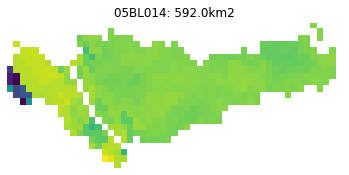

In [54]:
fig, ax = plt.subplots(figsize=(6, 6))

colored_maps = []
rows = 11
cols = 11
n = 0
r, c = 0, 0

stn = masked_stns_filtered[0]

base_image = get_sample_img(stn)
stn_dat = stations_df[stations_df['Station Number'] == stn]
stn_da = stn_dat['Gross Drainage Area (km2)']

base_img_array = np.array(base_image, dtype=np.int_)

remapped_colors_array = reset_bg_colors(base_img_array, count_array)

# ax.imshow(remapped_colors_array, cmap='viridis_r', interpolation='nearest', alpha=1)
ax.imshow(remapped_colors_array, cmap='viridis_r', interpolation='nearest', alpha=1)

ax.axis('off')
ax.set_title(stn + ': {:.1f}km2'.format(stn_da.values[0]))

ValueError: supplied range of [-inf, 12.488224454223836] is not finite

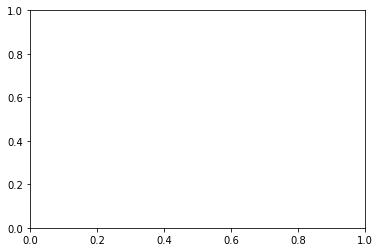

In [55]:
plt.hist(count_array.flatten(), density=True)

In [ ]:
bad_stns = [
    '08NE006', '05AB005', '08LE024', '05AB005', '05BL027', '08MF068', '08MF065',
    '05CB004', '08HA001', '05FC002', '08NL069', '08MH103', '08NL070', '08HB002',
    '08MH016', '08MG026', '08LG068', '08MH056', '08ME027', '08MF062', '08HB048',
    '08HB032', '08LE077', '08HA016', '08LF100',
]
print(sorted(bad_stns))

In [21]:
masked_stns_filtered = [e for e in masked_stns_filtered if len(event_dict[e].keys()) > 0]
masked_stns_filtered = [e for e in masked_stns_filtered if e not in bad_stns]

station_data = stations_df[stations_df['Station Number'].isin(masked_stns_filtered)]
station_data = station_data.sort_values('Gross Drainage Area (km2)', ascending=False)

# print(station_data[['Station Number', 'Gross Drainage Area (km2)']].head())
print(len(masked_stns_filtered))

102


In [22]:
# construct precipitation histograms
spatial_precip_dict = {}
for stn in station_data['Station Number'].values:
    spatial_precip_dict[stn] = construct_precip_histogram(stn)

initial shape of count array =  (47, 47)


/home/danbot/Documents/code/cuda_env/lib/python3.6/site-packages/ipykernel_launcher.py:90: RuntimeWarning: divide by zero encountered in log


initial shape of count array =  (32, 47)
initial shape of count array =  (32, 48)
initial shape of count array =  (32, 58)
initial shape of count array =  (50, 33)


KeyboardInterrupt: 

In [ ]:
for i in range(1,54):
    if 104 % i == 0:
        print(i)

/home/danbot/Documents/code/cuda_env/lib/python3.6/site-packages/ipykernel_launcher.py:83: RuntimeWarning: divide by zero encountered in log


05CA004 (0/104) process time: 11.12 s
08ND012 (1/104) process time: 14.65 s
05DB002 (2/104) process time: 11.05 s
05CA002 (3/104) process time: 8.28 s
08LE027 (4/104) process time: 11.81 s
05CC013 (5/104) process time: 6.81 s
05BJ004 (6/104) process time: 9.89 s
05BM014 (7/104) process time: 5.81 s
05BL019 (8/104) process time: 5.96 s
05CE006 (9/104) process time: 14.85 s
08LB069 (10/104) process time: 4.45 s
08NK018 (11/104) process time: 5.35 s
05BL014 (12/104) process time: 11.30 s
08NH130 (13/104) process time: 3.92 s
08HA010 (14/104) process time: 5.79 s
05CD007 (15/104) process time: 4.74 s
05BL013 (16/104) process time: 3.18 s
05CE012 (17/104) process time: 2.42 s
05CA012 (18/104) process time: 5.99 s
05CC011 (19/104) process time: 4.46 s
05CB002 (20/104) process time: 8.29 s
08NH005 (21/104) process time: 5.93 s
08JE004 (22/104) process time: 4.56 s
08NF001 (23/104) process time: 8.02 s
08KA001 (24/104) process time: 3.41 s
08NL050 (25/104) process time: 3.72 s
08MG001 (26/104)

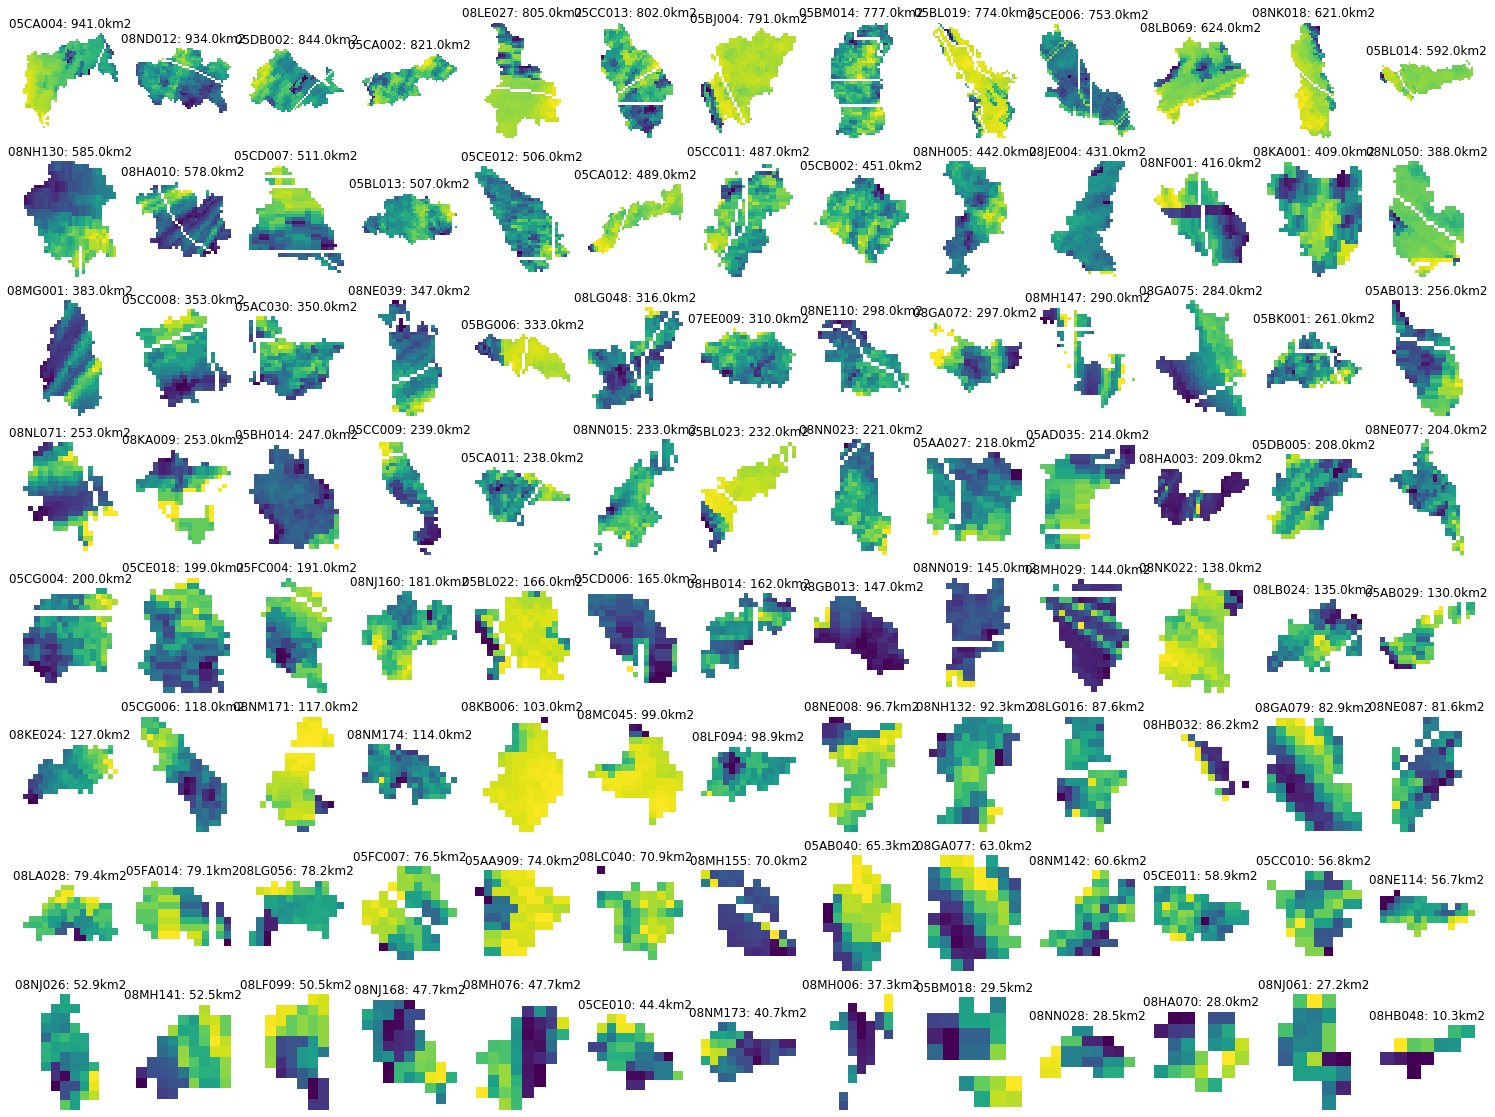

In [57]:
colored_maps = []
rows = 8
cols = 13
n = 0
r, c = 0, 0

fig, ax = plt.subplots(rows, cols, figsize=(26, 20))

for stn in station_data['Station Number'].values:
    t0 = time.time()
    base_image = get_sample_img(stn)   
    stn_dat = stations_df[stations_df['Station Number'] == stn]
    stn_da = stn_dat['Gross Drainage Area (km2)']
#     ax[r, c].imshow(base_image, alpha=0.5)
    

    t1 = time.time()
    print('{} ({}/{}) process time: {:.2f} s'.format(stn, n, len(masked_stns_filtered),t1-t0))
    base_img_array = np.array(base_image, dtype=np.int_)
    remapped_colors_array = reset_bg_colors(base_img_array, colorized_img_array)
    ax[r, c].imshow(remapped_colors_array, cmap='viridis_r', interpolation='nearest', alpha=1)

    ax[r, c].axis('off')
    ax[r, c].set_title(stn + ': {:.1f}km2'.format(stn_da.values[0]))
    c += 1
    if c == cols:
        c = 0
        r += 1

    n += 1

# plt.axis('off')

In [51]:
fig.savefig('spatial_precip_grid_plot_names.png', dpi=400, pad_inches=0, bbox_inches=0)

## Reconstruct Hydrograph

In [58]:
grids = []
n = 0
# stations_1 = stations[:5]
for stn in ['05BM014']:
    print(stn)
    print('{} ({}/{})'.format(stn, n, len(stations)))
    grids.append((stn, create_plot_grid(stn)))
    n += 1
    
show(arrange_plots_into_grid(grids[0]))

05BM014
05BM014 (0/126)
Station: 05BM014 (777.0 km^2)
